In [103]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tstrippy
from astropy import units as u
from astropy import constants as const
import numericalErrorFunctions as NEF
import datetime
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [2]:
GCdata          =   tstrippy.Parsers.baumgardtMWGCs().data
MWparams        =   tstrippy.Parsers.potential_parameters.pouliasis2017pii()
MWrefframe      =   tstrippy.Parsers.potential_parameters.MWreferenceframe()
x,y,z,vx,vy,vz  =   NEF.load_globular_clusters_in_galactic_coordinates(MWrefframe)
G = const.G
G=G.to(tstrippy.Parsers.unitbasis['G'])

In [3]:
# get the crossing time of the clusters 
vGCs = np.sqrt(vx**2 + vy**2 + vz**2)
rGCS = np.sqrt(x**2 + y**2 + z**2)
tcrossGCs = ((rGCS / vGCs) * u.Unit(tstrippy.Parsers.unitbasis['time'])).to(u.yr)
# get the internal dynamical time 
tdyn=np.sqrt(GCdata['rh_m']**3 / (G*GCdata['Mass'])).to(u.yr)

In [4]:
nbins = int(np.ceil(len(GCdata)))
binednges = 10**np.linspace(np.log10(tdyn.min().value), np.log10(tcrossGCs.max().value), nbins+1)

In [10]:
indexes = [tdyn.argmin(), np.argmin(np.abs(tdyn-np.median(tdyn))), tdyn.argmax()]
NP = 1000
labels = [r"$\mathrm{Most~dense}$", r"$\mathrm{Median}$", r"$\mathrm{Least~dense}$"]
index = indexes[0]
xp,yp,zp,vxp,vyp,vzp=tstrippy.ergodic.isotropicplummer(G.value,GCdata['Mass'][index].value,GCdata['rh_m'][index].value, NP)
rp,vp = np.sqrt(xp**2 + yp**2 + zp**2), np.sqrt(vxp**2 + vyp**2 + vzp**2)
tcrossP = rp/vp
tcrossP = (tcrossP*u.Unit(tstrippy.Parsers.unitbasis['time'])).to(u.yr)
tmin=tcrossP.min()
index= indexes[-1]
xp,yp,zp,vxp,vyp,vzp=tstrippy.ergodic.isotropicplummer(G.value,GCdata['Mass'][index].value,GCdata['rh_m'][index].value, NP)
rp,vp = np.sqrt(xp**2 + yp**2 + zp**2), np.sqrt(vxp**2 + vyp**2 + vzp**2)
tcrossP = rp/vp
tcrossP = (tcrossP*u.Unit(tstrippy.Parsers.unitbasis['time'])).to(u.yr)
tmax=tcrossP.max()
nbins = int(np.sqrt(NP))
bins = 10**np.linspace(np.log10(tmin.value), np.log10(tmax.value), nbins+1)

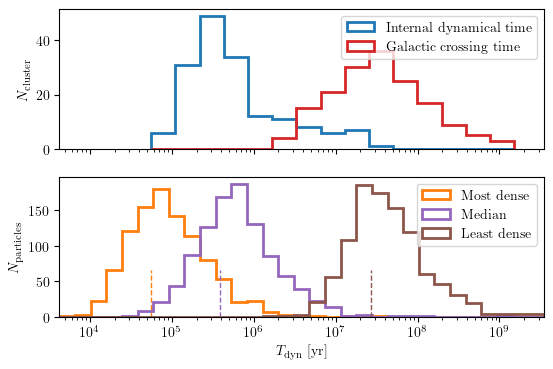

In [11]:
fig,axis=plt.subplots(2,1,figsize=(8.25-2,4),sharex=True, gridspec_kw={'height_ratios': [1, 1]})
axis[0].hist(tdyn.value, bins=binednges,  histtype='step', color='tab:blue', lw=2, label=r"$\mathrm{Internal~dynamical~time}$")
axis[0].hist(tcrossGCs.value, bins=binednges,  histtype='step', color='tab:red', lw=2, label=r"$\mathrm{Galactic~crossing~time}$")
axis[0].set_xscale('log')
axis[1].set_xlabel(r'$T_{\mathrm{dyn}}~[\mathrm{yr}]$', fontsize="medium")
axis[0].set_ylabel(r'$N_{\mathrm{cluster}}$', fontsize="medium")
ylims = axis[0].get_ylim()
axis[0].set_ylim(0, ylims[1])
# axis[0].set_xlim(3e4,5e9)
axis[0].legend(fontsize="medium", loc='best')

colors = ['tab:orange', 'tab:purple', 'tab:brown']
for i in range(len(indexes)):
    index = indexes[i]
    xp,yp,zp,vxp,vyp,vzp=tstrippy.ergodic.isotropicplummer(G.value,GCdata['Mass'][index].value,GCdata['rh_m'][index].value, NP)
    rp,vp = np.sqrt(xp**2 + yp**2 + zp**2), np.sqrt(vxp**2 + vyp**2 + vzp**2)
    tcrossP = rp/vp
    tcrossP = (tcrossP*u.Unit(tstrippy.Parsers.unitbasis['time'])).to(u.yr)
    axis[1].hist(tcrossP.value, bins=bins, histtype='step', lw=2, label=labels[i],color=colors[i])
    axis[1].vlines(tdyn[index].value, 0, NP/15, color=colors[i], linestyle='--', lw=1, )

axis[1].set_xlim(tmin.value, tmax.value)
axis[1].legend(fontsize="medium", loc='best')
axis[1].set_xscale('log')
axis[1].set_ylabel(r'$N_{\mathrm{particles}}$', fontsize="medium")

fig.savefig("../../images/GCsystemCharacteristicTimes.png", bbox_inches='tight', dpi=300)

# Crossing time within a cluster? 
What's a good timestep for the dynamics within a cluster?

In [154]:
index = indexes[1]
NP = 100 
xp,yp,zp,vxp,vyp,vzp=tstrippy.ergodic.isotropicplummer(G.value,GCdata['Mass'][index].value,GCdata['rh_m'][index].value, NP)
rp,vp = np.sqrt(xp**2 + yp**2 + zp**2), np.sqrt(vxp**2 + vyp**2 + vzp**2)
tcrossP = rp/vp
dt=np.median(tcrossP)/1000
print(dt*1e9,"median")
print(tdyn[index]/1000, "cluster")
print(dt)
dt = 10**3 * 10**-9
print(dt)

517.5024699548325 median
389.2937774656306 yr cluster
5.175024699548325e-07
1.0000000000000002e-06


In [155]:
plummerRadius = tstrippy.ergodic.convertHalfMassRadiusToPlummerRadius(GCdata['rh_m'][index].value)
Mass = GCdata['Mass'][index].value

integrationtime = .01*u.Gyr
integrationtime=integrationtime.to(tstrippy.Parsers.unitbasis['time']).value
NSTEPS = int(integrationtime/dt)
currentime = 0 


staticgalaxy = ["plummer", [G.value, Mass, plummerRadius]]
initialkinetmatics = [xp, yp, zp, vxp, vyp, vzp]
integrationparams = [currentime, dt, NSTEPS]
print(NSTEPS, NP)


10227 100


In [156]:
calc_time_per_step = 120e-9
print(calc_time_per_step*NSTEPS*NP, "seconds")

0.12272399999999999 seconds


In [157]:
tstrippy.integrator.deallocate()
tstrippy.integrator.setinitialkinematics(*initialkinetmatics)
tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
tstrippy.integrator.setintegrationparameters(*integrationparams)
startime = datetime.datetime.now()
xt,yt,zt,vxt,vyt,vzt=tstrippy.integrator.leapfrogintime(NSTEPS,NP)
endtime = datetime.datetime.now()
comptime = endtime - startime
print(f"Integration took {comptime} seconds")
tstrippy.integrator.deallocate()

Integration took 0:00:00.066475 seconds


In [158]:
# measure the potential energy NOW 
phi = np.zeros_like(xt)
T = np.zeros_like(xt)
for i in range(NP):
    _,_,_,phi[i,:]=tstrippy.potentials.plummer(staticgalaxy[1],xt[i],yt[i],zt[i])
    T[i,:] = 0.5 * (vxt[i]**2 + vyt[i]**2 + vzt[i]**2)
E = T + phi

In [159]:
timestemps = np.linspace(0, integrationtime, NSTEPS+1)

In [160]:
E0=E[:,0]
E0=E0[:,np.newaxis]
errE = np.abs((E - E0) / E0)

In [161]:
vmin = E0.min()
vmax = E0.max() 
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.rainbow
colors = cmap(norm(E[:,0]))


(0.0, 0.01022712165045695)

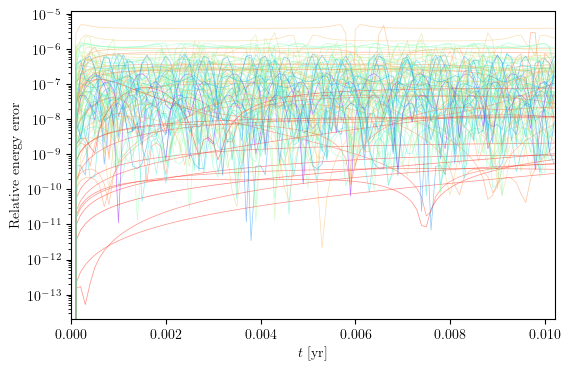

In [162]:
NSKIP = 100
fig,axis = plt.subplots(1, 1, figsize=(8.25-2, 4))
for i in range(NP):
    axis.plot(timestemps[::NSKIP], errE[i,::NSKIP], lw=0.5, alpha=0.5,color=colors[i])
axis.set_yscale("log")
axis.set_xlabel(r'$t~[\mathrm{yr}]$', fontsize="medium")
axis.set_ylabel(r'$\mathrm{Relative~energy~error}$', fontsize="medium")
axis.set_xlim(0, integrationtime)